# M4 | Research Investigation Notebook

In this notebook, you will do a research investigation of your chosen dataset in teams. You will begin by formally selecting your research question (task 0), then processing your data (task 1), creating a predictive model (task 2), and evaluating your model's results (task 3).

Please upload your solved notebook to Moodle (under [Milestone 4 Submission](https://moodle.epfl.ch/mod/assign/view.php?id=1199557)) adding your team name in title, example: `m4-lernnavi-teamname.ipynb`. Please run all cells before submission so we can grade effectively.



## Brief overview of Lernnavi
[Lernnavi](https://www.lernnavi.ch) is an instrument for promoting part of the basic technical study skills in German and mathematics.

Lernnavi's dataset is formatted in three main tables:
* *users*: demographic information of users.
* *events*: events done by the users in the platform.
* *transactions*: question and answer solved by user.

You should provide arguments and justifications for all of your design decisions throughout this investigation. You can use your M3 responses as the basis for this discussion.

In [1]:
# Import the tables of the data set as dataframes.
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import scipy as sc

# Scikit-learn package imports
from sklearn import feature_extraction, model_selection, metrics

# PyBKT package imports
from pyBKT.models import Model

# PyAFM package imports
from pyafm.custom_logistic import CustomLogistic

DATA_DIR = 'data' # You many change the directory

users = pd.read_csv('{}/users.csv.gz'.format(DATA_DIR))
events = pd.read_csv('{}/events.csv.gz'.format(DATA_DIR))
transactions = pd.read_csv('{}/transactions.csv.gz'.format(DATA_DIR))

In [2]:
topics=pd.read_csv('{}/topics_translated.csv.gz'.format(DATA_DIR))
topics_trees=pd.read_csv('{}/topic_trees.csv.gz'.format(DATA_DIR))
documents=pd.read_csv('{}/documents.csv.gz'.format(DATA_DIR))
learn_sessions=pd.read_csv('{}/learn_sessions_transactions.csv.gz'.format(DATA_DIR))

In [3]:
transactions['user_id']=transactions['user_id'].astype(int)

## Task 0: Research Question

**Research question:**
*Your chosen research question goes here*

## Task 1: Data Preprocessing

In this section, you are asked to preprocess your data in a way that is relevant for the model. Please include 1-2 visualizations of features / data explorations that are related to your downstream prediction task.

Different approaches we have to try:

1. Ways of considering partial answers:
    - as 0 (incorrect)
    - as 1 (correct)
    - as -1 (not answered)-the least logical
    - as 1 if answered >50% correct,0 otherwise
    
2. Answers:
    - can be given only on tasks of type 'level check'
    - can be given on all types of tasks

3. Acceptance of session:
    - consider only accepted sessions
    - consider any
    
4. Closeness of session:
    - any
    - closed

5. Filter users:
    - allow any number of sessions
    - only users with many sessions

In [4]:
learn_transaction=pd.merge(learn_sessions,transactions[['transaction_id','user_id','evaluation']],on='transaction_id').copy()

In [5]:
learn_transaction.shape

(497263, 9)

In [6]:
#We assume that answers can be given only on tasks of type check and no answers on tasks of type learn
learn_transaction=learn_transaction[((learn_transaction['type_id']==2)  & (learn_transaction['evaluation'].notna())) | ((learn_transaction['type_id']==1)  & (learn_transaction['evaluation'].isna()))].copy()

In [7]:
learn_transaction.shape

(211541, 9)

In [8]:
learn_transaction['correct']=learn_transaction['evaluation'].fillna(-1) #not given
#learn_transaction['correct']=np.where((learn_transaction['correct']=='CORRECT') ,1,np.where(learn_transaction['correct']==-1,-1,0)) #PARTIAL as incorrect
learn_transaction['correct']=np.where((learn_transaction['correct']=='CORRECT') | (learn_transaction['correct']=='PARTIAL'),1,np.where(learn_transaction['correct']==-1,-1,0)) #PARTIAL as correct

In [9]:
learn_transaction=pd.merge(learn_transaction,topics,left_on='topic_id',right_on='id').copy()

In [10]:
#acceptance
#learn_transaction=learn_transaction[learn_transaction['is_accepted']==1].reset_index().copy()

In [11]:
learn_transaction.shape

(211541, 16)

In [12]:
#closeness of sessions
#learn_transaction=learn_transaction[learn_transaction['is_closed']==1].reset_index().copy()

In [13]:
learn_transaction.shape

(211541, 16)

In [14]:
learn_transaction['subject']=np.where(learn_transaction['math']==1,'Math','German')

In [15]:
df_subject=learn_transaction[['user_id','learn_session_id','transaction_id','subject','correct']].sort_values(by=['learn_session_id','transaction_id'],ascending=True)
df_subject=df_subject.rename(columns={"subject": "skill_name"}).copy()

In [16]:
df_subject['prior_success']=np.where(df_subject.correct==1,1,0)
df_subject['prior_failure']=np.where(df_subject.correct==0,1,0)
df_subject['prior_success']=df_subject.groupby(['user_id','skill_name']).prior_success.cumsum()-1
df_subject['prior_success']=df_subject['prior_success'].apply(lambda x: 0 if x<0 else x)
df_subject['prior_failure']=df_subject.groupby(['user_id','skill_name']).prior_failure.cumsum()-1
df_subject['prior_failure']=df_subject['prior_failure'].apply(lambda x: 0 if x<0 else x)

In [17]:
df_subject.reset_index(inplace=True,drop=True)
df_subject.head(20)

,user_id,learn_session_id,transaction_id,skill_name,correct,prior_success,prior_failure
0,387605,5297,385885,Math,-1,0,0
1,387605,5301,385899,Math,-1,0,0
2,387605,5309,385955,German,-1,0,0
3,387605,5432,387905,German,-1,0,0
4,387605,5433,387906,German,-1,0,0
5,387605,5436,387921,German,-1,0,0
6,387605,5444,387954,Math,-1,0,0
7,387605,5445,387962,Math,-1,0,0
8,387615,5542,388166,German,1,0,0
9,387615,5542,388167,German,1,1,0


Exclude users that were not very active to reduce a little bit dataset (because it is too big to apply these models)

In [18]:
df_subject.shape

(211541, 7)

In [19]:
user_activity=df_subject.groupby('user_id').count().sort_values(by='correct').copy()
#include_users=user_activity[['learn_session_id']].sort_values(by='learn_session_id',ascending=False).iloc[:2000,:].index

include_users=user_activity.index.to_frame().sample(2500).index #random 2500 of users
df_subject=df_subject[df_subject['user_id'].isin(include_users)].copy()

In [20]:
df_subject.shape

(55214, 7)

## Task 2: Model Building
----
In this section, we will perform: 

(i) a Bayesian Knowledge Tracing (BKT) model, 

(ii) an Additive Factor Model (AFM),

(iii) a Performance Factor Analysis (PFA) model and

(iv) a Deep learning knowledge tracing (DKT) model<br>
on the skills 'Math', and 'German'

We will complete this section through five main tasks:

Task 2.1: Group k-fold initialization.

Task 2.2: BKT evaluation.

Task 2.3: AFM evaluation.

Task 2.4: PFA evaluation.

Task 2.5: DKT evaluation.

We take a look at the skills included in the data set:

In [21]:
df_subject['skill_name'].unique()

array(['German', 'Math'], dtype=object)

### Task 2.1

In [22]:
def create_iterator(data):
    '''
    Create an iterator to split interactions in data in 2 folds, with the same student not appearing in two diverse folds.
    :param data:        Dataframe with student's interactions.
    :return:            An iterator.
    '''
    # Both passing a matrix with the raw data or just an array of indexes works
    X = np.arange(len(data.index)) 
    # Groups of interactions are identified by the user id (we do not want the same user appearing in two folds)
    groups = data['user_id'].values 
    return model_selection.GroupKFold(n_splits=2).split(X, groups=groups)

Let's check the output of this function and a few properties of the iterator.

In [23]:
tested_user_ids = set()
for iteration, (train_index, test_index) in enumerate(create_iterator(df_subject)):
    user_ids = df_subject['user_id'].unique()
    train_user_ids = df_subject.iloc[train_index]['user_id'].unique()
    test_user_ids = df_subject.iloc[test_index]['user_id'].unique()
    print('Iteration:', iteration)
    print('Intersection between train and test user ids:', set(train_user_ids) & set(test_user_ids))
    print('All user ids in train and test user union:', len(set(train_user_ids).union(set(test_user_ids))) == len(user_ids))
    print('User ids tested more than once:', set(tested_user_ids) & set(test_user_ids))
    tested_user_ids = tested_user_ids.union(set(test_user_ids))

Iteration: 0
Intersection between train and test user ids: set()
All user ids in train and test user union: True
User ids tested more than once: set()
Iteration: 1
Intersection between train and test user ids: set()
All user ids in train and test user union: True
User ids tested more than once: set()


On a given iteration, no user appears in both training and test sets. The union of the users in both training and test sets given us the full set of user ids in the dataset. Each user appears in the test set exactly once.

### Task 2.2

In this task we evaluate a `BKT model` with all default parameters in pyBKT, through a `10-fold user-stratified cross-validation`, computing the following performance metrics: `RMSE` and `AUC`.

In [24]:
rmse_bkt, auc_bkt = [], []
for iteration, (train_index, test_index) in enumerate(create_iterator(df_subject)):
    
    # Split data in training and test sets
    X_train, X_test = df_subject.iloc[train_index], df_subject.iloc[test_index]
    
    # Initialize and fit the model
    model = Model(seed=0)
    %time model.fit(data=X_train) 
    
    # Compute RMSE
    train_rmse = model.evaluate(data=X_train, metric='rmse')
    test_rmse = model.evaluate(data=X_test, metric='rmse')
    rmse_bkt.append(test_rmse)
    
    # Compute AUC
    train_auc = model.evaluate(data=X_train, metric='auc')
    test_auc = model.evaluate(data=X_test, metric='auc')
    auc_bkt.append(test_auc)
    
    # Print progress
    print('Iteration:', iteration, 'RMSE', (train_rmse, test_rmse), 'AUC', (train_auc, test_auc))

CPU times: user 15.4 s, sys: 0 ns, total: 15.4 s
Wall time: 15.7 s
Iteration: 0 RMSE (0.30005797631061243, 0.3035670764344806) AUC (0.6470486739899388, 0.658567106605954)
CPU times: user 23 s, sys: 0 ns, total: 23 s
Wall time: 23.2 s
Iteration: 1 RMSE (0.30238322810746604, 0.29992693970111295) AUC (0.6970234155679772, 0.6731224496169628)


Finally, we show the mean and the standard deviation of the RMSE and AUC across folds.

In [25]:
print('For BKT model mean RMSE={0} and standard deviation of RMSE is {1}'.format(round(np.mean(rmse_bkt),5), round(np.std(rmse_bkt),5)))
print('For BKT model mean AUC={0} and standard deviation of AUC is {1}'.format(round(np.mean(auc_bkt),5), round(np.std(auc_bkt),5)))

For BKT model mean RMSE=0.30175 and standard deviation of RMSE is 0.00182
For BKT model mean AUC=0.66584 and standard deviation of AUC is 0.00728


In [26]:
df_subject = df_subject[df_subject['correct'] != -1].copy()
df_subject.shape

(42254, 7)

### Task 2.3

In this task we evaluate an `AFM model` with all default parameters through a `10-fold user-stratified cross-validation`, computing the following performance metrics: `RMSE` and `AUC`.

In [27]:
def read_as_student_step(data):    
    skills, opportunities, corrects, user_ids = [], [], [], []
    
    for row_id, (_, row) in enumerate(data.iterrows()):
        
        # Get attributes for the current interaction 
        user_id = row['user_id']
        skill_name = row['skill_name']
        correct = row['correct']
        prior_success = row['prior_success']
        prior_failure = row['prior_failure']
        
        # Update the number of opportunities this student had with this skill
        opportunities.append({skill_name: prior_success + prior_failure})
        
        # Update information in the current 
        skills.append({skill_name: 1})

        # Answer info
        corrects.append(correct)
        
        # Student info
        user_ids.append({user_id: 1})
        
    return (skills, opportunities, corrects, user_ids)

In [28]:
def prepare_data_afm(skills, opportunities, corrects, user_ids):

    sv = feature_extraction.DictVectorizer()
    qv = feature_extraction.DictVectorizer()
    ov = feature_extraction.DictVectorizer()
    S = sv.fit_transform(user_ids)
    Q = qv.fit_transform(skills)
    O = ov.fit_transform(opportunities)
    X = sc.sparse.hstack((S, Q, O))
    y = np.array(corrects)

    return (X.toarray(), y)

Prepare the X and y arrays to be used to evaluate the AFM model. 

In [29]:
%time skills, opportunities, corrects, user_ids = read_as_student_step(df_subject)
%time X, y = prepare_data_afm(skills, opportunities, corrects, user_ids)

CPU times: user 2.16 s, sys: 32.2 ms, total: 2.19 s
Wall time: 2.23 s
CPU times: user 413 ms, sys: 1.02 s, total: 1.43 s
Wall time: 2.52 s


In [30]:
X.shape

(42254, 1491)

In [31]:
rmse_afm, auc_afm = [], []
for iteration, (train_index, test_index) in enumerate(create_iterator(df_subject)):
    
    # Split data in training and test sets
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    print(X_train.shape,X_test.shape)
    
    # Initialize and fit the model
    afm = CustomLogistic()
    %time afm.fit(X_train, y_train)
    
    # Make predictions 
    y_train_pred = afm.predict_proba(X_train)
    y_test_pred = afm.predict_proba(X_test)
    
    # Compute RMSE
    train_rmse = metrics.mean_squared_error(y_train, y_train_pred, squared=False)
    test_rmse = metrics.mean_squared_error(y_test, y_test_pred, squared=False)
    rmse_afm.append(test_rmse)
    
    # Compute AUC
    train_auc = metrics.roc_auc_score(y_train, y_train_pred)
    test_auc = metrics.roc_auc_score(y_test, y_test_pred)
    auc_afm.append(test_auc)
    
    # Print progress
    print('Iteration:', iteration, 'RMSE', (train_rmse, test_rmse), 'AUC', (train_auc, test_auc))

(21127, 1491) (21127, 1491)
CPU times: user 52.1 s, sys: 40.4 s, total: 1min 32s
Wall time: 1min 34s
Iteration: 0 RMSE (0.29707783259475185, 0.3001260138064536) AUC (0.7764117176057626, 0.6312887800643971)
(21127, 1491) (21127, 1491)
CPU times: user 54 s, sys: 37.5 s, total: 1min 31s
Wall time: 1min 32s
Iteration: 1 RMSE (0.2886791789007086, 0.30933992511866254) AUC (0.756492085954479, 0.673626923347984)


In [32]:
a=[]
for i in afm.predict_proba(X_train):
    if i not in a:
        a.append(i)

Finally, we show the mean and the standard deviation of the RMSE and AUC across folds.

In [33]:
print('For AFM model mean RMSE={0} and standard deviation of RMSE is {1}'.format(round(np.mean(rmse_afm),5), round(np.std(rmse_afm),5)))
print('For AFM model mean AUC={0} and standard deviation of AUC is {1}'.format(round(np.mean(auc_afm),5), round(np.std(auc_afm),5)))

For AFM model mean RMSE=0.30473 and standard deviation of RMSE is 0.00461
For AFM model mean AUC=0.65246 and standard deviation of AUC is 0.02117


### Task 2.4

In this task we evaluate a `PFA model` with all default parameters through a `10-fold user-stratified cross-validation`, computing the following performance metrics: `RMSE` and `AUC`.

In [34]:
def read_as_success_failure(data):
    n_succ, n_fail = [], []

    # Create the n_succ and n_fail variables required by pyAFM
    for i, row in data.iterrows():
        n_succ.append({row['skill_name']: int(row['prior_success'])})
        n_fail.append({row['skill_name']: int(row['prior_failure'])})
        
    return n_succ, n_fail

In [35]:
def prepare_data_pfa(skills, corrects, user_ids, n_succ, n_fail):
    
    s = feature_extraction.DictVectorizer()
    q = feature_extraction.DictVectorizer()
    succ = feature_extraction.DictVectorizer()
    fail = feature_extraction.DictVectorizer()
    S = s.fit_transform(user_ids)
    Q = q.fit_transform(skills)
    succ = succ.fit_transform(n_succ)
    fail = fail.fit_transform(n_fail)
    X = sc.sparse.hstack((S, Q, succ, fail))
    y = np.array(corrects)

    return (X.toarray(), y)

Prepare the X and y arrays to be used to evaluate the PFA model. 

In [36]:
%time n_succ, n_fail = read_as_success_failure(df_subject)
%time X, y = prepare_data_pfa(skills, corrects, user_ids, n_succ, n_fail)

CPU times: user 2.16 s, sys: 182 ms, total: 2.34 s
Wall time: 2.9 s
CPU times: user 511 ms, sys: 468 ms, total: 979 ms
Wall time: 2.19 s


In [37]:
X.shape

(42254, 1493)

In [38]:
rmse_pfa, auc_pfa = [], []
for iteration, (train_index, test_index) in enumerate(create_iterator(df_subject)):
    # Split data in training and test sets
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    # Initialize and fit the model
    pfa = CustomLogistic()
    %time pfa.fit(X_train, y_train)
    # Make predictions 
    y_train_pred = pfa.predict_proba(X_train)
    y_test_pred = pfa.predict_proba(X_test)
    # Compute RMSE
    train_rmse = metrics.mean_squared_error(y_train, y_train_pred, squared=False)
    test_rmse = metrics.mean_squared_error(y_test, y_test_pred, squared=False)
    rmse_pfa.append(test_rmse)
    # Compute AUC
    train_auc = metrics.roc_auc_score(y_train, y_train_pred)
    test_auc = metrics.roc_auc_score(y_test, y_test_pred)
    auc_pfa.append(test_auc)
    # Print progress
    print('Iteration:', iteration, 'RMSE', (train_rmse, test_rmse), 'AUC', (train_auc, test_auc))

CPU times: user 1min 45s, sys: 1min 4s, total: 2min 50s
Wall time: 2min 52s
Iteration: 0 RMSE (0.2955189263167715, 0.29513147981667137) AUC (0.7825981562556741, 0.7190206249307712)
CPU times: user 1min 17s, sys: 46.3 s, total: 2min 3s
Wall time: 2min 5s
Iteration: 1 RMSE (0.28717198147134304, 0.30717635953987166) AUC (0.7644840019403162, 0.7549543520801237)


Finally, we show the mean and the standard deviation of the RMSE and AUC across folds. 

In [39]:
print('For PFA model mean RMSE={0} and standard deviation of RMSE is {1}'.format(round(np.mean(rmse_pfa),5), round(np.std(rmse_pfa),5)))
print('For PFA model mean AUC={0} and standard deviation of AUC is {1}'.format(round(np.mean(auc_pfa),5), round(np.std(auc_pfa),5)))

For PFA model mean RMSE=0.30115 and standard deviation of RMSE is 0.00602
For PFA model mean AUC=0.73699 and standard deviation of AUC is 0.01797


### Task 2.5

In this task we evaluate a `DKT model` with 10 epochs, computing the following performance metrics: `RMSE` and `AUC`.

In [40]:
# Tensorflow
import tensorflow as tf

2022-05-22 18:41:44.323395: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-22 18:41:44.338534: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [41]:
def prepare_seq(df):
    # Step 1 - Enumerate skill id
    df['skill'], skill_codes = pd.factorize(df['skill_name'], sort=True)

    # Step 2 - Cross skill id with answer to form a synthetic feature
    df['skill_with_answer'] = df['skill'] * 2 + df['correct']

    # Step 3 - Convert to a sequence per user id and shift features 1 timestep
    seq = df.groupby('user_id').apply(lambda r: (r['skill_with_answer'].values[:-1], r['skill'].values[1:], r['correct'].values[1:],))
    
    # Step 4- Get max skill depth and max feature depth
    skill_depth = df['skill'].max() 
    features_depth = df['skill_with_answer'].max() + 1

    return seq, features_depth, skill_depth

In [42]:
def prepare_data(seq, params, features_depth, skill_depth):
    
    # Step 1 - Get Tensorflow Dataset
    dataset = tf.data.Dataset.from_generator(generator=lambda: seq, output_types=(tf.int32, tf.int32, tf.float32))

    # Step 2 - Encode categorical features and merge skills with labels to compute target loss.
    dataset = dataset.map(
        lambda feat, skill, label: (
            tf.one_hot(feat, depth=features_depth),
            tf.concat(values=[tf.one_hot(skill, depth=skill_depth), tf.expand_dims(label, -1)], axis=-1)
        )
    )

    # Step 3 - Pad sequences per batch
    dataset = dataset.padded_batch(
        batch_size=params['batch_size'],
        padding_values=(params['mask_value'], params['mask_value']),
        padded_shapes=([None, None], [None, None]),
        drop_remainder=True
    )

    return dataset.repeat(), len(seq)

In [43]:
params = {}
params['batch_size'] = 32
params['mask_value'] = -1.0

In [44]:
# Obtain indexes
train_index, test_index = next(create_iterator(df_subject))
# Split the data
X_train, X_test = df_subject.iloc[train_index], df_subject.iloc[test_index]

In [45]:
# Obtain indexes for necessary validation set
train_val_index, val_index = next(create_iterator(X_train))
# Split the training data into training and validation
X_train_val, X_val = X_train.iloc[train_val_index], X_train.iloc[val_index]

seq, features_depth, skill_depth = prepare_seq(df_subject)
seq_train = seq[X_train.user_id.unique()]
seq_val = seq[X_train_val.user_id.unique()]
seq_test = seq[X_test.user_id.unique()]

tf_train, length = prepare_data(seq_train, params, features_depth, skill_depth)
tf_val, val_length  = prepare_data(seq_val, params, features_depth, skill_depth)
tf_test, test_length = prepare_data(seq_test, params, features_depth, skill_depth)

params['train_size'] = int(length // params['batch_size'])
params['val_size'] = int(val_length // params['batch_size'])
params['test_size'] = int(test_length // params['batch_size'])

2022-05-22 18:43:52.693437: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-05-22 18:43:52.693487: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-05-22 18:43:52.693521: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (noto.epfl.ch): /proc/driver/nvidia/version does not exist
2022-05-22 18:43:52.693951: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [46]:
params['verbose'] = 1 # Verbose = {0,1,2}
params['best_model_weights'] = 'weights/bestmodel' # File to save the model
params['optimizer'] = 'adam' # Optimizer to use
params['backbone_nn'] = tf.keras.layers.RNN # Backbone neural network
params['recurrent_units'] = 16 # Number of RNN units
params['epochs'] = 10  # Number of epochs to train
params['dropout_rate'] = 0.3 # Dropout rate

In [47]:
def get_target(y_true, y_pred, mask_value=params['mask_value']):
    
    # Get skills and labels from y_true
    mask = 1. - tf.cast(tf.equal(y_true, mask_value), y_true.dtype)
    y_true = y_true * mask

    skills, y_true = tf.split(y_true, num_or_size_splits=[-1, 1], axis=-1)

    # Get predictions for each skill
    y_pred = tf.reduce_sum(y_pred * skills, axis=-1, keepdims=True)

    return y_true, y_pred

In [48]:
class AUC(tf.keras.metrics.AUC):
    def update_state(self, y_true, y_pred, sample_weight=None):
        true, pred = get_target(y_true, y_pred)
        super(AUC, self).update_state(y_true=true, y_pred=pred, sample_weight=sample_weight)

class RMSE(tf.keras.metrics.RootMeanSquaredError):
    def update_state(self, y_true, y_pred, sample_weight=None):
        true, pred = get_target(y_true, y_pred)
        super(RMSE, self).update_state(y_true=true, y_pred=pred, sample_weight=sample_weight)
        
def CustomBinaryCrossEntropy(y_true, y_pred):    
    y_true, y_pred = get_target(y_true, y_pred)
    return tf.keras.losses.binary_crossentropy(y_true, y_pred)   

In [49]:
def create_model(nb_features, nb_skills, params):
    
    # Create the model architecture
    inputs = tf.keras.Input(shape=(None, nb_features), name='inputs')
    x = tf.keras.layers.Masking(mask_value=params['mask_value'])(inputs)
    x = tf.keras.layers.SimpleRNN(params['recurrent_units'], return_sequences=True, dropout=params['dropout_rate'])(x)
    dense = tf.keras.layers.Dense(nb_skills, activation='sigmoid')
    outputs = tf.keras.layers.TimeDistributed(dense, name='outputs')(x)
    model = tf.keras.models.Model(inputs=inputs, outputs=outputs, name='DKT')

    # Compile the model
    model.compile(loss=CustomBinaryCrossEntropy, 
                  optimizer=params['optimizer'], 
                  metrics=[AUC(), RMSE()])
    
    return model

model = create_model(features_depth, skill_depth, params)

In [50]:
model.summary()


Model: "DKT"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, None, 4)]         0         
                                                                 
 masking (Masking)           (None, None, 4)           0         
                                                                 
 simple_rnn (SimpleRNN)      (None, None, 16)          336       
                                                                 
 outputs (TimeDistributed)   (None, None, 1)           17        
                                                                 
Total params: 353
Trainable params: 353
Non-trainable params: 0
_________________________________________________________________


In [51]:
ckp_callback = tf.keras.callbacks.ModelCheckpoint(params['best_model_weights'], save_best_only=True, save_weights_only=True)
history = model.fit(tf_train, epochs=params['epochs'], steps_per_epoch=params['train_size'], 
                    validation_data=tf_val,  validation_steps = params['val_size'], 
                    callbacks=[ckp_callback], verbose=params['verbose'])

Epoch 1/10
23/23 [==============================] - 16s 568ms/step - loss: 0.6333 - auc: 0.6757 - root_mean_squared_error: 0.6038 - val_loss: 0.5486 - val_auc: 0.6597 - val_root_mean_squared_error: 0.5302
Epoch 2/10
23/23 [==============================] - 12s 520ms/step - loss: 0.5897 - auc: 0.6770 - root_mean_squared_error: 0.5060 - val_loss: 0.5211 - val_auc: 0.6648 - val_root_mean_squared_error: 0.4694
Epoch 3/10
23/23 [==============================] - 12s 524ms/step - loss: 0.5720 - auc: 0.6771 - root_mean_squared_error: 0.4699 - val_loss: 0.5148 - val_auc: 0.6657 - val_root_mean_squared_error: 0.4592
Epoch 4/10
23/23 [==============================] - 12s 538ms/step - loss: 0.5684 - auc: 0.6695 - root_mean_squared_error: 0.4641 - val_loss: 0.5134 - val_auc: 0.6642 - val_root_mean_squared_error: 0.4571
Epoch 5/10
23/23 [==============================] - 10s 428ms/step - loss: 0.5672 - auc: 0.6737 - root_mean_squared_error: 0.4624 - val_loss: 0.5129 - val_auc: 0.6656 - val_root_me

In [52]:
model.load_weights(params['best_model_weights'])
metrics_dkt_small = model.evaluate(tf_test, verbose=params['verbose'], steps = params['test_size'])

23/23 [==============================] - 3s 128ms/step - loss: 0.4918 - auc: 0.6546 - root_mean_squared_error: 0.4306


In [53]:
# Binary cross entropy, AUC, RMSE
metrics_dkt_small

[0.4917687475681305, 0.654579222202301, 0.4305565059185028]

In [54]:
auc_dkt = np.empty(np.shape(auc_bkt))
auc_dkt.fill(metrics_dkt_small[1])

rmse_dkt = np.empty(np.shape(rmse_bkt))
rmse_dkt.fill(metrics_dkt_small[2])

## Task 3: Model Evaluation
---
In this task, we use metrics to evaluate the model.

By performing a user-stratified 2-fold cross validation and monitoring the Root Mean Squared Error (RMSE) and the Area Under the ROC Curve (AUC) as performance metrics. Then, we visually report the RMSE and AUC scores achieved by the student's models in the user-stratified 2-fold cross validation, in such a way that the models' performance can be easily and appropriately compared against each other.

Task 3.1: Performance metrics plotting.

Task 3.2: Performance metrics discussion.


### Task 3.1 Metrics representation

In this task, we visually report the RMSE and AUC scores achieved by the three student's models in the user-stratified 2-fold cross validation performed in Task 1.2, 1.3, 1.4 and 1.5 respectively, in such a way that the models' performances can be easily and appropriately compared against each other. 

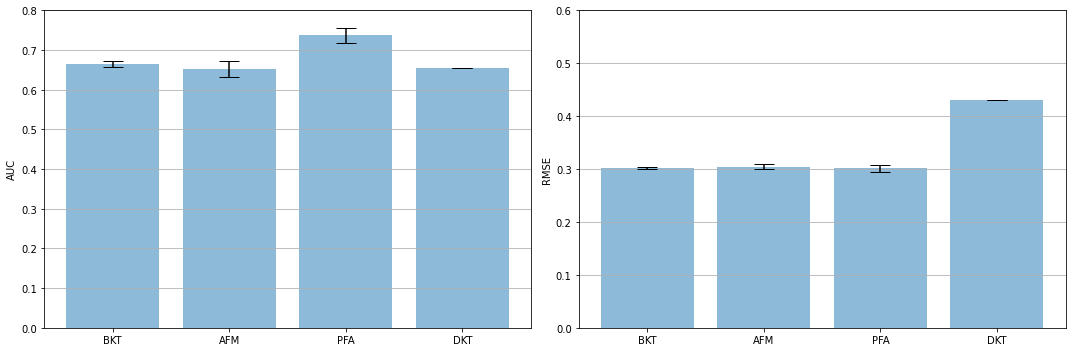

In [55]:
m = {'AUC': {'BKT': auc_bkt, 'AFM': auc_afm, 'PFA': auc_pfa, 'DKT': auc_dkt}, 'RMSE': {'BKT': rmse_bkt, 'AFM': rmse_afm, 'PFA': rmse_pfa, 'DKT': rmse_dkt}}
limits = {'AUC': 0.8, 'RMSE': 0.6}

plt.figure(figsize=(15, 5))

for metric_idx, metric_key in enumerate(m.keys()):
    
    # Create the subplot for the current metric
    plt.subplot(1, len(m), metric_idx + 1)
    # Compute means, standard deviations, and labels
    means, errors, labels = [], [], []
    for model_key, model_scores in m[metric_key].items():
        means.append(np.mean(model_scores))
        errors.append(np.std(model_scores))
        labels.append(model_key)
    
    # Plot values
    x_pos = np.arange(len(labels))
    plt.bar(x_pos, means, yerr=errors, align='center', alpha=0.5, ecolor='black', capsize=10)
    # Make decorations
    plt.grid(axis='y')
    plt.xticks(x_pos, labels)
    plt.ylabel(metric_key)
    plt.ylim(0, limits[metric_key])

# Show the plot
plt.tight_layout()
plt.show()